In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
import warnings

### The paper did not give any details on model selection that let us think that maybe the model chosen enhanced the results and showed that trends data had added value. No particular attention was given to timeseries specifics, as we know one have to be very careful when dealing with timeseries (stationarity problems) and model selection.

### The following results will explore the timeseries structure et model selection in rigourously.

<AxesSubplot:xlabel='Period'>

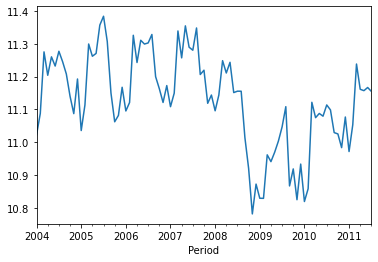

In [2]:
# Loading and processing data
df=pd.read_csv(r".\merged_autos.csv")
df['Period'] = pd.to_datetime(df['Period'])
df['log_sales'] = np.log(df['sales'])
df['sales'] = np.log(df['sales'])
df.set_index('Period',inplace=True)
df['sales'].plot()

### By plotting the timeseries of sales we can clearly see that it is not stationary, let us use Augmented dickey-fuller to verify

In [3]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['sales'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.740847
p-value: 0.410199


### We fail to reject the null hypothesis , hence we fail to reject non stationarity. We will try to make the timeseries stationary in order to build an AR overall model. We will modify the timeserie as log(S(t)/S(t-1))

<AxesSubplot:xlabel='Period'>

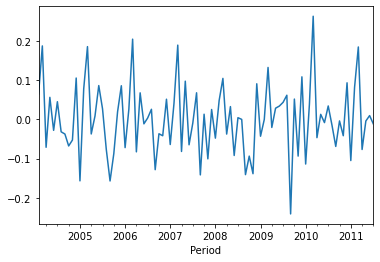

In [4]:
#Calculating log difference to stationarize the timeserie
df['sales'] = df['sales']-df['sales'].shift(1)
df['suvs'] = df['suvs']-df['suvs'].shift(1)
df['insurance'] = df['insurance']-df['insurance'].shift(1)


df.dropna(inplace=True)
df['sales'].plot()

### The time serie looks stationary on different periods: from 2004 to 2008 and  from 2008 to 2014. It does not look stationary in the whole period as the std seems to change between the 2 periods. Let us check our observations by using the Augmented dickey fuller test.

In [5]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['sales'])
print('ADF Statistic all period: %f' % result[0])
print('p-value all period: %f' % result[1])

ADF Statistic all period: -1.788685
p-value all period: 0.386093


### As described earlier, we fail to reject the non-stationarity on all the period but we notice that the pvalue is now smaller when calculating the log difference

In [6]:
period_delimiter='04-01-2008'
from statsmodels.tsa.stattools import adfuller
result_period1 = adfuller(df.loc[df.index <= period_delimiter,'sales'])
result_period2 = adfuller(df.loc[df.index > period_delimiter,'sales'])

print('ADF Statistic up to '+period_delimiter+': %f' % result_period1[0])
print('p-value up to '+period_delimiter+': %f' % result_period1[1])
print('\n')
print('ADF Statistic from '+period_delimiter+': %f' % result_period2[0])
print('p-value from '+period_delimiter+': %f' % result_period2[1])

ADF Statistic up to 04-01-2008: -6.675553
p-value up to 04-01-2008: 0.000000


ADF Statistic from 04-01-2008: -4.859335
p-value from 04-01-2008: 0.000042


### We can see that by delimiting in 04-01-2008, we have 2 timeseries that are stationary. Since we are trying to build an AR model we are going to be interested by the partial autocorelation function.

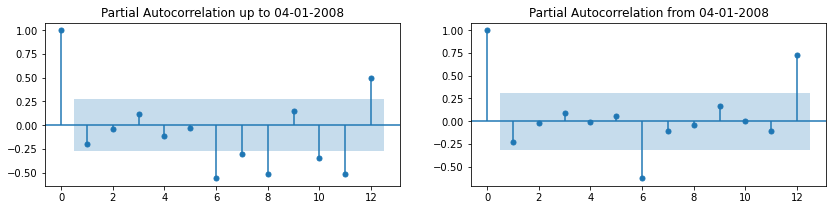

In [7]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, axs = plt.subplots(1, 2, figsize=(14,3))

# axs[0].set_title("p vs. odds")
# axs[0].plot(p, odds)
# axs[0].set_xlabel("p")
# axs[0].set_ylabel("odds")

plot_pacf(df.loc[df.index <= period_delimiter,'sales'], lags=12,ax=axs[0],title='Partial Autocorrelation up to '+period_delimiter)
plot_pacf(df.loc[df.index > period_delimiter,'sales'], lags=12,ax=axs[1],title='Partial Autocorrelation from '+period_delimiter)
plt.show()

### Both periods shows significance for lags 6 and 12. The first period has more lags that are signification:7,8,10 and 11. The choice of lag 12 was a good choice in the paper. Let us choose lag 6 instead as we can have more data for accurate predictions.

### Let us fit an AR model for both periods and analyse the fit.


In [24]:
lags_period_1=[6,12]
AR_endo_period_1 = AutoReg(endog=df.loc[df.index <= period_delimiter,'sales'], lags=lags_period_1).fit()
AR_endo_period_1.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  sales   No. Observations:                   51
Model:             Restr. AutoReg(12)   Log Likelihood                  63.916
Method:               Conditional MLE   S.D. of innovations              0.047
Date:                Sun, 13 Dec 2020   AIC                             -5.910
Time:                        19:10:46   BIC                             -5.740
Sample:                    02-01-2005   HQIC                            -5.849
                         - 04-01-2008                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.035e-05      0.008     -0.004      0.997      -0.015       0.015
sales.L6      -0.1571      0.096     -1.637      0.102      -0.345       0.031
sales.L12      0.7155      0.094      7.576      0.000       0.530       0.901
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0443           -0.0000j            1.0443           -0.5000
AR.2            -0.8769           -0.5063j            1.0125           -0.4167
AR.3            -0.8769           +0.5063j            1.0125            0.4167
AR.4            -0.5222           -0.9044j            1.0443           -0.3333
AR.5            -0.5222           +0.9044j            1.0443            0.3333
AR.6            -0.0000           -1.0125j            1.0125           -0.2500
AR.7            -0.0000           +1.0125j            1.0125            0.2500
AR.8             0.5222           -0.9044j            1.0443           -0.1667
AR.9             0.5222           +0.9044j            1.0443            0.1667
AR.10            1.0443           -0.0000j            1.0443           -0.0000
AR.11            0.8769           -0.5063j            1.0125           -0.0833
AR.12            0.8769           +0.5063j            1.0125            0.0833
------------------------------------------------------------------------------
"""

In [25]:
lags_period_2=[6,12]
AR_endo_period_2 = AutoReg(endog=df.loc[df.index > period_delimiter,'sales'], lags=lags_period_2).fit()
AR_endo_period_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  sales   No. Observations:                   39
Model:             Restr. AutoReg(12)   Log Likelihood                  36.484
Method:               Conditional MLE   S.D. of innovations              0.063
Date:                Sun, 13 Dec 2020   AIC                             -5.244
Time:                        19:11:06   BIC                             -5.052
Sample:                    05-01-2009   HQIC                            -5.187
                         - 07-01-2011                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0105      0.012      0.867      0.386      -0.013       0.034
sales.L6      -0.1803      0.162     -1.111      0.266      -0.498       0.138
sales.L12      0.6122      0.159      3.860      0.000       0.301       0.923
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0619           -0.0000j            1.0619           -0.5000
AR.2            -0.8851           -0.5110j            1.0220           -0.4167
AR.3            -0.8851           +0.5110j            1.0220            0.4167
AR.4            -0.5309           -0.9196j            1.0619           -0.3333
AR.5            -0.5309           +0.9196j            1.0619            0.3333
AR.6            -0.0000           -1.0220j            1.0220           -0.2500
AR.7            -0.0000           +1.0220j            1.0220            0.2500
AR.8             0.5309           -0.9196j            1.0619           -0.1667
AR.9             0.5309           +0.9196j            1.0619            0.1667
AR.10            1.0619           -0.0000j            1.0619           -0.0000
AR.11            0.8851           -0.5110j            1.0220           -0.0833
AR.12            0.8851           +0.5110j            1.0220            0.0833
------------------------------------------------------------------------------
"""

In [27]:
lags_period_all=[6,12]
AR_endo_period_all = AutoReg(endog=df['sales'], lags=lags_period_all, exog=df[["suvs", "insurance"]]).fit()
AR_endo_period_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             AutoReg Model Results                              
================================================================================
Dep. Variable:                    sales   No. Observations:                   90
Model:             Restr. AutoReg-X(12)   Log Likelihood                 124.701
Method:                 Conditional MLE   S.D. of innovations              0.049
Date:                  Sun, 13 Dec 2020   AIC                             -5.881
Time:                          19:16:05   BIC                             -5.700
Sample:                      02-01-2005   HQIC                            -5.809
                           - 07-01-2011                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0005      0.006     -0.086      0.931      -0.011       0.010
sales.L6      -0.1731      0.076     -2.289      0.022      -0.321      -0.025
sales.L12      0.6927      0.073      9.477      0.000       0.549       0.836
suvs           0.5545      0.139      3.999      0.000       0.283       0.826
insurance     -0.2083      0.092     -2.262      0.024      -0.389      -0.028
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0491           -0.0000j            1.0491           -0.5000
AR.2            -0.8776           -0.5067j            1.0134           -0.4167
AR.3            -0.8776           +0.5067j            1.0134            0.4167
AR.4            -0.5245           -0.9085j            1.0491           -0.3333
AR.5            -0.5245           +0.9085j            1.0491            0.3333
AR.6             0.0000           -1.0134j            1.0134           -0.2500
AR.7             0.0000           +1.0134j            1.0134            0.2500
AR.8             0.5245           -0.9085j            1.0491           -0.1667
AR.9             0.5245           +0.9085j            1.0491            0.1667
AR.10            1.0491           -0.0000j            1.0491           -0.0000
AR.11            0.8776           -0.5067j            1.0134           -0.0833
AR.12            0.8776           +0.5067j            1.0134            0.0833
------------------------------------------------------------------------------
"""

### For both periods choosing lag 1 and 6 are stastically significant, hence we can chose this model for the rolling model. Our goal will be to predict the log difference and we can retrieve log(Sales) predicted by adding the last value.

In [10]:
#Adding shift for outsample rolling predictions calculations
from statsmodels.regression.rolling import RollingOLS
for i in np.arange(1,13,1):
    df['sales_'+str(i)]=df['sales'].shift(i)
df['intercept']=1

#Functions calculating rolling AR out_sample predictions
#Base Model
def rolling_AR_endo(df, window,lags=[1,12]):
    results = []
    regressor_names=['intercept']+['sales_'+str(i) for i in lags]
#     regressor_names =  ['intercept','sales_1','sales_12']
    for i in np.arange(window,len(df)):
        df_training=df.iloc[0:i]
        outsample=df.iloc[i]
        
        result_fit = AutoReg(endog=df_training['sales'], lags=lags).fit()
        result_pred = np.sum(np.array(result_fit.params)*np.array(outsample[regressor_names]))
        result_pred=result_pred + df_training.iloc[-1]['log_sales']
        results.append(result_pred)
    return results
#Trends model
def rolling_AR_exo(df, window, lags=[1,12], exogenous_regressors=["suvs", "insurance"]):
    results=[]
    regressor_names = ['intercept']+['sales_'+str(i) for i in lags] +exogenous_regressors
#     exogenous_regressors=["suvs", "insurance"]
    
    for i in np.arange(window, len(df)):
        df_training=df.iloc[0:i]
        outsample=df.iloc[i]
       
        result_fit=AutoReg(endog=df_training['sales'], lags=lags, exog=df_training[exogenous_regressors]).fit()
        result_pred = np.sum(np.array(result_fit.params)*np.array(outsample[regressor_names]))
        result_pred=result_pred + df_training.iloc[-1]['log_sales']
        results.append(result_pred)
    return results



In [22]:
import warnings
warnings.filterwarnings("ignore")

selected_lags=[6,12]
#Outsample AutoReg for the base model
df.loc[df.index >= "2005-07-01",'Baseline_Predictions'] = rolling_AR_endo(df,17,lags=selected_lags)

#Autoreg cannot be fitted for the first iteration hence we use k=18 and replace the first prediction by the baseline
df.loc[df.index >= "2005-08-01",'Trends_Predictions'] = rolling_AR_exo(df, 18, lags=selected_lags)
df.loc["2005-07-01",'Trends_Predictions']=df.loc["2005-07-01",'Baseline_Predictions']
#Keeping only the dates where we have predictions
df_results=df[df.index >= "2005-07-01"]

#Calculating MAE
baseline_mae = mean_absolute_error(df_results['log_sales'], df_results['Baseline_Predictions'])
trends_mae = mean_absolute_error(df_results['log_sales'], df_results['Trends_Predictions'])
improvement = (baseline_mae-trends_mae)/baseline_mae


print(f"MAE of the baseline model: {baseline_mae*100:.2f}%")
print(f"MAE of the trends model: {trends_mae*100:.2f}%")
print(f"MAE improvement: {improvement*100:.2f}%")


MAE of the baseline model: 4.75%
MAE of the trends model: 4.30%
MAE improvement: 9.47%


<AxesSubplot:xlabel='Period'>

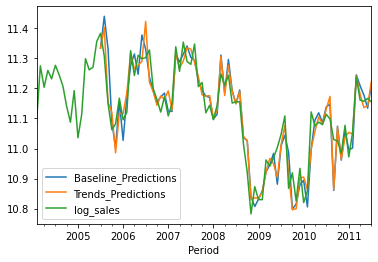

In [32]:
df[['Baseline_Predictions','Trends_Predictions','log_sales']].plot()

In [23]:
#keeping results only for recession period
df_results_recession = df_results.loc[(df_results.index >= "2007-12-01") & (df_results.index <= "2009-06-01")]

baseline_mae_recession = mean_absolute_error(df_results_recession['log_sales'], df_results_recession['Baseline_Predictions'])
trends_mae_recession = mean_absolute_error(df_results_recession['log_sales'], df_results_recession['Trends_Predictions'])
improvement_recession = (baseline_mae_recession-trends_mae_recession)/baseline_mae_recession

print(f"MAE of the baseline model during recession: {baseline_mae_recession*100:.2f}%")
print(f"MAE of the trends model during recession: {trends_mae_recession*100:.2f}%")
print(f"MAE improvement during recession: {improvement_recession*100:.1f}%")

MAE of the baseline model during recession: 3.93%
MAE of the trends model during recession: 3.63%
MAE improvement during recession: 7.6%


In [31]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr-chi2test'
def grangers_causality_matrix(X_train, variables, test = 'ssr_chi2test', verbose=False):
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(X_train[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value
    dataset.columns = [var + '_x' for var in variables]
    dataset.index = [var + '_y' for var in variables]
    return dataset
grangers_causality_matrix(df[['sales','suvs','insurance']], variables = ['sales','suvs','insurance'])

,sales_x,suvs_x,insurance_x
sales_y,1.0,0.0000,0.0
suvs_y,0.0,1.0000,0.0
insurance_y,0.0,0.0007,1.0


,sales,suvs,insurance,log_sales,sales_1,sales_2,sales_3,sales_4,sales_5,sales_6,sales_7,sales_8,sales_9,sales_10,sales_11,sales_12,intercept,Baseline_Predictions,Trends_Predictions
Period,,,,,,,,,,,,,,,,,,,
2004-02-01,0.064664,-0.12,-0.01,11.087987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
2004-03-01,0.187227,0.07,-0.08,11.275214,0.064664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
2004-04-01,-0.071235,-0.07,0.01,11.203979,0.187227,0.064664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
2004-05-01,0.056142,0.05,0.01,11.260121,-0.071235,0.187227,0.064664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
2004-06-01,-0.028022,-0.05,0.08,11.232100,0.056142,-0.071235,0.187227,0.064664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-03-01,0.184540,-0.01,0.00,11.238252,0.081641,-0.105014,0.093182,-0.041735,-0.004013,-0.069047,-0.015048,0.034129,-0.008294,0.012762,-0.046688,0.262876,1,11.245255,11.241816
2011-04-01,-0.076815,-0.05,-0.01,11.161437,0.184540,0.081641,-0.105014,0.093182,-0.041735,-0.004013,-0.069047,-0.015048,0.034129,-0.008294,0.012762,-0.046688,1,11.208938,11.180889
2011-05-01,-0.004187,-0.08,-0.02,11.157250,-0.076815,0.184540,0.081641,-0.105014,0.093182,-0.041735,-0.004013,-0.069047,-0.015048,0.034129,-0.008294,0.012762,1,11.178520,11.136329
